In [4]:
import pandas as pd
import pandas_ta as ta

def read_metatrader_csv(csv_path : str):
    df = pd.read_csv(csv_path, sep="\\t")
    print(df.columns)
    df['Gmt time'] = df['<DATE>'] + ' ' + df['<TIME>']

    df.rename(columns={'<CLOSE>' : 'Close', '<HIGH>': 'High', '<OPEN>' : 'Open', '<LOW>':'Low'}, inplace=True)

    df["Gmt time"]=df["Gmt time"].str.replace(".000","")
    df['Gmt time']=pd.to_datetime(df['Gmt time'],format='%Y.%m.%d %H:%M:%S')
    df.drop(columns =['<DATE>', '<TIME>'], inplace=True)
    df=df[df.High!=df.Low]
    df.set_index("Gmt time", inplace=True)
    df.drop(columns=['<TICKVOL>', '<SPREAD>', '<VOL>'], inplace=True)

    return df

def feature_engineering(df : pd.DataFrame, i : int, n :int):

    df['ema_9'] = ta.ema(df.Close, length=9)
    df['ema_21'] = ta.ema(df.Close, length=21)

    df['ema_12'] = ta.ema(df.Close, length=12)
    df['ema_26'] = ta.ema(df.Close, length=26)


    rsi_14 = ta.rsi(df.Close, length=14)
    cci = ta.cci(df['High'], df['Low'], df['Close'], window=20, constant=0.015)
    my_bbands = ta.bbands(df.Close, length=15, std=1.5)
    atr_10 = ta.atr(df.High, df.Low, df.Close, length=10)


    df = df.join(rsi_14)
    df = df.join(atr_10)
    df = df.join(cci)
    df = df.join(my_bbands)

    # Adding Simple Moving Averages
    df['sma5'] = ta.sma(df['Close'],window = 5)
    df['sma10'] = ta.sma(df['Close'],window = 10)
    df['sma15'] = ta.sma(df['Close'],window = 15)
    df['sma20'] = ta.sma(df['Close'],window = 20)
    df['sma30'] = ta.sma(df['Close'],window = 30)
    df['sma50'] = ta.sma(df.Close,length=50)
    df['sma80'] = ta.sma(df['Close'],window = 80)
    df['sma100'] = ta.sma(df['Close'],window = 100)
    df['sma200'] = ta.sma(df['Close'],window = 200)

    # Adding Price to Simple Moving Averages ratios

    df['sma5_ratio'] = df['Close'] / df['sma5']
    df['sma10_ratio'] = df['Close'] / df['sma10']
    df['sma20_ratio'] = df['Close'] / df['sma20']
    df['sma30_ratio'] = df['Close'] / df['sma30']
    df['sma50_ratio'] = df['Close'] / df['sma50']
    df['sma80_ratio'] = df['Close'] / df['sma80']
    df['sma100_ratio'] = df['Close'] / df['sma100']
    df['sma200_ratio'] = df['Close'] / df['sma200']

    df['rsi'] = ta.rsi(df['Close'],length=14)
    df['cci'] = ta.cci(df['High'], df['Low'], df['Close'], window=20, constant=0.015)
    bb_indicator = ta.bbands(df['Close'], length=20, std=2)

    df=df.join(bb_indicator)


    # Adding features derived from the indicators above

    df['rsi_overbought'] = (df['rsi'] >= 70).astype(int)
    df['rsi_oversold'] = (df['rsi'] <= 30).astype(int)
    df['above_bb_high'] = (df['Close'] >= df['BBU_20_2.0']).astype(int)
    df['below_bb_low'] = (df['Close'] <= df['BBL_20_2.0']).astype(int)
    df['cci_high'] = (df['cci'] >= 120).astype(int)
    df['cci_low'] = (df['cci'] <= -120).astype(int)

    df['sma5 > sma20'] = (df['sma5'] > df['sma20']).astype(int)
    df['crossover_signal_5_20'] = df['sma5 > sma20'].diff()

    df['sma10 > sma50'] = (df['sma10'] > df['sma50']).astype(int)
    df['crossover_signal_10_50'] = df['sma10 > sma50'].diff()

    df['sma20 > sma50'] = (df['sma20'] > df['sma50']).astype(int)
    df['crossover_signal_20_50'] = df['sma20 > sma50'].diff()

    df['sma50 > sma200'] = (df['sma50'] > df['sma200']).astype(int)
    df['crossover_signal_50_200'] = df['sma50 > sma200'].diff()

    df['sma100 > sma200'] = (df['sma100'] > df['sma200']).astype(int)
    df['crossover_signal_100_200'] = df['sma100 > sma200'].diff()

    df['ema_9 > ema21'] = (df['ema_9'] > df['ema_21']).astype(int)
    df['crossover_ema_9_21'] = df['ema_9 > ema21'].diff()

    df['ema_12 > ema26'] = (df['ema_12'] > df['ema_26']).astype(int)
    df['crossover_ema_12_26'] = df['ema_12 > ema26'].diff()


    df['close_above_bbl_15_1.5'] = (df['Close'] >= df['BBL_15_1.5']).astype(int)
    df['close_above_bbl_20_2'] = (df['Close'] >= df['BBL_20_2.0']).astype(int)

    df['close_bellow_bbu_15_1.5'] = (df['Close'] >= df['BBU_15_1.5']).astype(int)


    df.dropna(inplace = True)
    return df


df = read_metatrader_csv('https://github.com/saeedeyvazy/forex/blob/main/src/downloads/mt/EURUSD_M5_201001040000_202410170705.csv')
print(' Dataframe Read With Shape: ')
print (df.shape)

n = 10**3
df_list = [ feature_engineering(df[i:i+n], i, i+n) for i in range(0, df.shape[0], n)]

df = pd.concat(df_list)
ichimoku_data = ta.ichimoku(df['High'], df['Low'], df['Close'], tenkan = 9, kijun = 26, senkou = 52)
df = pd.concat([df, ichimoku_data[0]], axis=1)
macd = ta.macd(df.Close)
df.join(macd)

df.dropna(inplace = True)

print(' Dataframe After ichimoku and macd :' )
print(df.shape)


import numpy as np

df['five_times_trend'] = df['Close'].diff().rolling(5).sum()
df['ten_times_trend'] = df['Close'].diff().rolling(10).sum()

df['close_after_60_times'] = df['Close'].shift(-60) - df['Close']
df['close_after_30_times'] = df['Close'].shift(-30) - df['Close']
df['close_after_25_times'] = df['Close'].shift(-25) - df['Close']
df['close_after_20_times'] = df['Close'].shift(-20) - df['Close']

conditions = [df['five_times_trend'] < 0, df['five_times_trend'] == 0, df['five_times_trend'] > 0 ]
choices = [ 0, 1, 2]
df['five_times_trend_signal'] = np.select(conditions, choices)

conditions = [df['ten_times_trend'] < 0, df['ten_times_trend'] == 0, df['ten_times_trend'] > 0 ]
choices = [ 0, 1, 2]
df['ten_times_trend_signal'] = np.select(conditions, choices)

conditions = [df['close_after_20_times'] < -0.0002, df['close_after_20_times'] > 0.0002]
choices = [ 0, 2]
df['Target'] = np.select(conditions, choices)

conditions = [df['close_after_30_times'] < -0.0002, df['close_after_30_times'] > 0.0002 ]
choices = [ 0, 2]
df['Target2'] = np.select(conditions, choices, default=1)

conditions = [df['close_after_60_times'] < -0.0002, df['close_after_60_times'] > 0.0002 ]
choices = [ 0, 2]
df['Target3'] = np.select(conditions, choices, default=1)

conditions = [df['close_after_25_times'] < -0.0002, df['close_after_25_times'] > 0.0002 ]
choices = [ 0, 2]
df['Target4'] = np.select(conditions, choices, default=1)


print(' Dataframe After Adding targets columns :' )
print(df.shape)

df.dropna(inplace = True)
df.head(50)

<ipython-input-4-56e86ec52133>:5: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_csv(csv_path, sep="\\t")


Index(['<!DOCTYPE html>'], dtype='object')


KeyError: '<DATE>'

In [2]:
!pip install pandas_ta

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 2.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pandas_ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218909 sha256=2da9527f087a3866776219fa3c5e7edd5d1de14d88471e6d2b90718a07e26ca6
  Stored in directory: /root/.cache/pip/wheels/69/00/ac/f7fa862c34b0e2ef320175100c233377b4c558944f12474cf0
Successfully built pandas_ta


## Validating Four ML Model

In [ ]:
import logging, sys
logging.disable(sys.maxsize)
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import auc, accuracy_score
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

df.dropna(inplace=True)
target = df['Target4']

X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['Target','Target2', 'Target3', 'Target4', 'close_after_20_times','close_after_30_times', 'close_after_60_times', 'close_after_25_times'], axis=1), target, test_size=.3)


classifiers = [
    XGBClassifier(reg_alpha=.06, min_child_weight =2, max_depth=9, gamma=.2, learning_rate=.6, subsample =1, colsample_bytree=.95),
    LGBMClassifier(learning_rate=.2, colsample_bytree=.95,n_estimators=4000,num_leaves=1500,max_depth=40),
    # AdaBoostClassifier(random_state = 42, n_estimators=50, algorithm='SAMME.R', learning_rate=1.03),
    RandomForestClassifier(n_estimators=170, max_depth=60)
]

validation_result = {}

scores_list = list()
scores_mean_list = list()
test_accuracy_list = list()
k_folds = KFold(n_splits = 4)
feature_importances = list()

for clf in classifiers:
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', clf)
    ])

    print(f' Starting {type(clf).__name__} cross_val_score')
    scores = cross_val_score(pipeline, X_train, y_train, cv = 4, verbose=2, n_jobs=7)

    print(scores)
    print(f'{type(clf).__name__}: KFold Scores Mean= {scores.mean():.4f}')

    print(f' Starting Fitting {type(clf).__name__} ')
    pipeline.fit(X_train, y_train)
    test_accuracy = pipeline.score(X_test, y_test)

    print("Test accuracy:", test_accuracy)

    model = pipeline.named_steps['classifier']

    feature_importances.append(model.feature_importances_)
    scores_list.append(scores)
    test_accuracy_list.append(test_accuracy)
    scores_mean_list.append(scores.mean())


validation_result = {'Model' : [type(clf).__name__ for clf in classifiers],
                     'Mean KFold Score' : scores_mean_list,
                     'Test Accuracy ' : test_accuracy_list}

validation_result = pd.DataFrame(data=validation_result)
validation_result.set_index('Model', inplace=True)

validation_result.head(5)

 Starting XGBClassifier cross_val_score


[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done   4 out of   4 | elapsed:   40.9s finished


[0.76664571 0.76543203 0.76442481 0.765223  ]
XGBClassifier: KFold Scores Mean= 0.7654
 Starting Fitting XGBClassifier 
Test accuracy: 0.7691449090949679
 Starting LGBMClassifier cross_val_score


[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done   4 out of   4 | elapsed: 51.9min finished


[0.78833885 0.79002269 0.78882972 0.79113682]
LGBMClassifier: KFold Scores Mean= 0.7896
 Starting Fitting LGBMClassifier 
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.080599 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12055
[LightGBM] [Info] Number of data points in the train set: 731658, number of used features: 68
[LightGBM] [Info] Start training from score -0.871274
[LightGBM] [Info] Start training from score -1.823536
[LightGBM] [Info] Start training from score -0.867196
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positi

[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done   4 out of   4 | elapsed: 17.0min finished


[0.77774923 0.78313424 0.77955761 0.78068929]
RandomForestClassifier: KFold Scores Mean= 0.7803
 Starting Fitting RandomForestClassifier 
Test accuracy: 0.8050604492153243


,Mean KFold Score,Test Accuracy
Model,,
XGBClassifier,0.765431,0.769145
LGBMClassifier,0.789582,0.798886
RandomForestClassifier,0.780283,0.805060


In [ ]:
a = list()
shared_top_feature_list= list()

for i in range(0, len(feature_importances)):

    if i == 2:
       continue

    df_feature_importances = pd.DataFrame(feature_importances[i], index=X_train.columns, columns=['Importance']).sort_values('Importance', ascending=False)
    if i == 1:
        a.append(df_feature_importances[df_feature_importances.Importance > 200].index)

    else:
        a.append(df_feature_importances[df_feature_importances.Importance > .01].index)

for item in a:
    for inner in item:
        shared_top_feature_list.append(inner)


print((np.unique(shared_top_feature_list)).__len__())
print((np.unique(shared_top_feature_list)))
validation_result

ValueError: Shape of passed values is (72, 1), indices imply (22, 1)

## RandomForestClassifier Hyper Parameter Optimization

In [ ]:
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import GridSearchCV

from utils.grid_search_utils import table_grid_search

import pickle


X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['Target','Target2', 'Target3', 'Target4', 'close_after_20_times','close_after_30_times', 'close_after_60_times', 'close_after_25_times'], axis=1), df['Target4'], test_size=.3)


rf_clf = RandomForestClassifier(n_estimators=170, max_depth=60)


# min_samples_split=20, n_estimators=170
# rf_feature = pd.DataFrame(feature_importances[2], index=X_train.columns, columns=['Importance']).sort_values('Importance', ascending=False)
# rf_feature = rf_feature[rf_feature.Importance > .001]
X_train_new, X_test_new, y_train_new, y_test_new = X_train, X_test, y_train, y_test
    # train_test_split(df[rf_feature], df['Target4'], test_size=.3))


parameters = {
    # 'min_samples_leaf': [3, 5, 8],
    # 'min_samples_split': [3],
    # 'n_estimators': [170]
}
clf = GridSearchCV(rf_clf, parameters, verbose=2, n_jobs=10, cv=3)
clf.fit(X_train_new, y_train_new)

y_pred = clf.predict(X_test_new)

print("acc score : ", accuracy_score(y_test_new, y_pred))

table_grid_search(clf)

with open('randomforest.pickle', 'wb') as fp:
    pickle.dump(clf, fp)

clf.best_score_, clf.best_params_

Fitting 3 folds for each of 1 candidates, totalling 3 fits
acc score :  0.8144204305910342


,mean_test_score,mean_fit_time,mean_score_time
0,0.776248,836.399702,15.069206


(0.776247919109748, {})

In [ ]:
import pandas as pd

rf_pickle = pd.read_pickle(r'randomforest.pickle')
xgboost_pickle = pd.read_pickle(r'xgboost.pickle')
lgbm_pickle = pd.read_pickle(r'lgbm.pickle')

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['Target','Target2', 'Target3', 'Target4', 'close_after_20_times','close_after_30_times', 'close_after_60_times', 'close_after_25_times'], axis=1), df['Target4'], test_size=.3)


saved_model_feature_importance_list = [rf_pickle.best_estimator_.feature_importances_,
                                       xgboost_pickle.best_estimator_.feature_importances_,
                                       lgbm_pickle.best_estimator_.feature_importances_]

rf_feature_importance = pd.DataFrame(saved_model_feature_importance_list[0], index=X_train.columns, columns=['Importance']).sort_values('Importance', ascending=False)

xgboost_feature_importance = pd.DataFrame(saved_model_feature_importance_list[1], index=X_train.columns, columns=['Importance']).sort_values('Importance', ascending=False)

lgbm_feature_importance = pd.DataFrame(saved_model_feature_importance_list[2], index=X_train.columns, columns=['Importance']).sort_values('Importance', ascending=False)



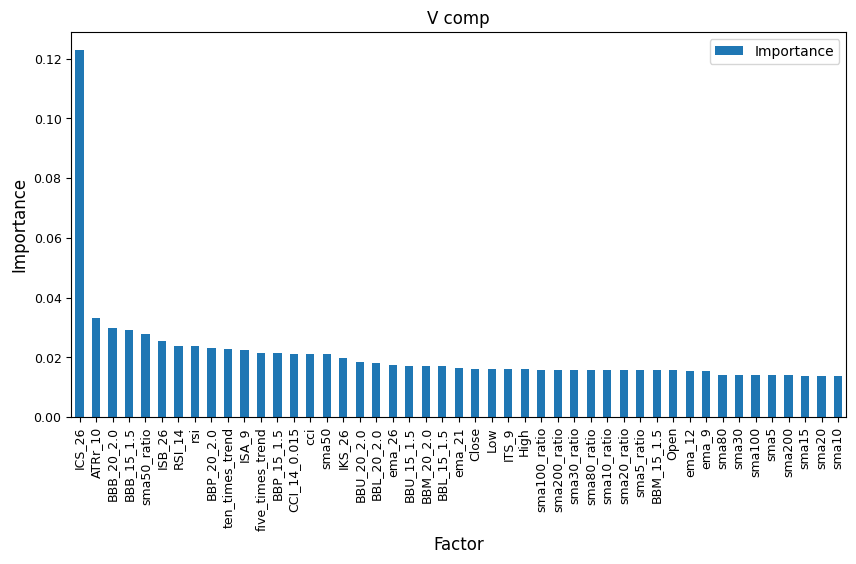

In [ ]:
import matplotlib.pyplot as plt
ax = rf_feature_importance[rf_feature_importance.Importance > .01].plot(kind='bar', title ="V comp", figsize=(10, 5), legend=True, fontsize=9)
ax.set_xlabel("Factor", fontsize=12)
ax.set_ylabel("Importance", fontsize=12)
plt.show()

In [ ]:
a = list()
shared_top_feature_list= list()
feature_importances = [lgbm_feature_importance[lgbm_feature_importance.Importance > 100000],
                       xgboost_feature_importance[xgboost_feature_importance.Importance > .014 ],
                       rf_feature_importance[rf_feature_importance.Importance > .01]]

for i in range(0, len(feature_importances)):
    df_feature_importances = feature_importances[i]
    a.append(df_feature_importances.index)

for item in a:
    for inner in item:
        shared_top_feature_list.append(inner)


print((np.unique(shared_top_feature_list)).__len__())
print(np.unique(shared_top_feature_list))

49
['ATRr_10' 'BBB_15_1.5' 'BBB_20_2.0' 'BBL_15_1.5' 'BBL_20_2.0'
 'BBM_15_1.5' 'BBM_20_2.0' 'BBP_15_1.5' 'BBP_20_2.0' 'BBU_15_1.5'
 'BBU_20_2.0' 'CCI_14_0.015' 'Close' 'High' 'ICS_26' 'IKS_26' 'ISA_9'
 'ISB_26' 'ITS_9' 'Low' 'Open' 'RSI_14' 'above_bb_high' 'cci' 'ema_12'
 'ema_21' 'ema_26' 'ema_9' 'five_times_trend' 'rsi' 'sma10' 'sma100'
 'sma100_ratio' 'sma10_ratio' 'sma15' 'sma20' 'sma200' 'sma200_ratio'
 'sma20_ratio' 'sma30' 'sma30_ratio' 'sma5' 'sma50' 'sma50 > sma200'
 'sma50_ratio' 'sma5_ratio' 'sma80' 'sma80_ratio' 'ten_times_trend']


In [ ]:
 table_grid_search(clf) # n_estimators=170, max_depth=60

NameError: name 'table_grid_search' is not defined

In [ ]:
table_grid_search(clf)

,mean_test_score,mean_fit_time,mean_score_time
0,0.755857,816.383315,10.410844


## XGBoostClassifier Hyper Paramater Optimization

In [ ]:
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import GridSearchCV

from utils.lwoku import RANDOM_STATE
from utils.grid_search_utils import plot_grid_search, table_grid_search

import pickle


X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['Target','Target2', 'Target3', 'Target4', 'close_after_20_times','close_after_30_times', 'close_after_60_times', 'close_after_25_times'], axis=1), df['Target4'], test_size=.3)


rf_clf = XGBClassifier(reg_alpha=.06, min_child_weight =2, max_depth=9, gamma=.2, learning_rate=.6, subsample =1, colsample_bytree=.95)


#
# rf_feature = pd.DataFrame(feature_importances[2], index=X_train.columns, columns=['Importance']).sort_values('Importance', ascending=False)
# rf_feature = rf_feature[rf_feature.Importance > .001]
X_train_new, X_test_new, y_train_new, y_test_new = X_train, X_test, y_train, y_test
# train_test_split(df[rf_feature], df['Target4'], test_size=.3))


parameters = {
    'min_child_weight' : range(1, 10 , 1)
}

clf = GridSearchCV(rf_clf, parameters, verbose=2, n_jobs=7, cv=3, scoring='accuracy')
print(f"Start Fitting GridSearchCV {XGBClassifier.__name__} : " )
clf.fit(X_train_new, y_train_new)

y_pred = clf.predict(X_test_new)

print("acc score : ", accuracy_score(y_test_new, y_pred))
table_grid_search(clf)
with open('xgboost.pickle', 'wb') as fp:
    pickle.dump(clf, fp)

clf.best_score_, clf.best_params_,

Start Fitting GridSearchCV XGBClassifier : 
Fitting 3 folds for each of 9 candidates, totalling 27 fits
acc score :  0.7694829527153513


,mean_test_score,mean_fit_time,mean_score_time,param_max_depth
8,0.764339,32.149819,0.85958,9


(0.7643393498055103, {'max_depth': 9})

## LGBMClassifier Hyper Parameter Optimization  

In [ ]:
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import GridSearchCV
from utils.grid_search_utils import plot_grid_search, table_grid_search

import pickle


X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['Target','Target2', 'Target3', 'Target4', 'close_after_20_times','close_after_30_times', 'close_after_60_times', 'close_after_25_times'], axis=1), df['Target4'], test_size=.3)


rf_clf = LGBMClassifier(learning_rate=.2, colsample_bytree=.95,n_estimators=4000,num_leaves=1500,max_depth=40)


#
# rf_feature = pd.DataFrame(feature_importances[2], index=X_train.columns, columns=['Importance']).sort_values('Importance', ascending=False)
# rf_feature = rf_feature[rf_feature.Importance > .001]
X_train_new, X_test_new, y_train_new, y_test_new = X_train, X_test, y_train, y_test
# train_test_split(df[rf_feature], df['Target4'], test_size=.3))


parameters = {

}

clf = GridSearchCV(rf_clf, parameters, verbose=2, n_jobs=4, cv=3, scoring='accuracy')
print(f"Start Fitting GridSearchCV {XGBClassifier.__name__} : " )
clf.fit(X_train_new, y_train_new)

y_pred = clf.predict(X_test_new)

print("acc score : ", accuracy_score(y_test_new, y_pred))
table_grid_search(clf)
with open('lgbm.pickle', 'wb') as fp:
    pickle.dump(clf, fp)

clf.best_score_, clf.best_params_

Start Fitting GridSearchCV XGBClassifier : 
Fitting 3 folds for each of 2 candidates, totalling 6 fits


KeyboardInterrupt: 

In [ ]:
print(np.mean(clf.cv_results_['std_test_score']))
table_grid_search(clf)

0.0006779592008963708


,mean_test_score,mean_fit_time,mean_score_time,param_n_estimators,param_num_leaves
0,0.784808,179.587156,21.965615,1000,400


In [ ]:
table_grid_search(clf)

,mean_test_score,mean_fit_time,mean_score_time,param_learning_rate
6,0.765471,39.461849,1.537211,0.6



## Models Parameter Optimization

In [ ]:
import pandas as pd
import pickle

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler


param_grid = {
    'RandomForest': {
        'model': RandomForestClassifier(),
        'params': {
            'classifier__n_estimators': [50, 100],
            'classifier__max_depth': [10, 20, 30],
            'classifier__min_samples_split': [20, 50, 70],
        }
    },
    'XGBoost': {
        'model': XGBClassifier(use_label_encoder=False, eval_metric='mlogloss'),
        'params': {
            'classifier__n_estimators': [100, 400, 700],
            'classifier__max_depth': [5, 7, 9],
            'classifier__learning_rate': [0.2, 0.3],
            'classifier__min_child_weight' : [5,10],
            'classifier__subsample' : [.7,1.0]
        }

    },
    'LightGBM': {
        'model': LGBMClassifier(),
        'params': {
            'classifier__n_estimators': [50, 100],
            'classifier__max_depth': [None, 10, 20],
            'classifier__learning_rate': [0.1, 0.2],
        }
    }
}
target = df['Target4']

shared_top_feature_list = np.unique(shared_top_feature_list)
X_train, X_test, y_train, y_test = train_test_split(df[shared_top_feature_list], target, test_size=.3)

best_models = {}

for model_name, model_info in param_grid.items():
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', model_info['model'])
    ])

    # Grid Search
    grid_search = GridSearchCV(pipeline, model_info['params'],  n_jobs=7, scoring='accuracy', verbose=1, cv=3)

    print("Start Fitting......")
    grid_search.fit(X_train, y_train)
    print("End Fitting......")
    y_pred = grid_search.predict(X_test)

    print(f"Accuracy Score For {model_name} : ", accuracy_score(y_test, y_pred))

    best_models[model_name] = {
        'best_estimator': grid_search.best_estimator_,
        'best_score': grid_search.best_score_,
        'best_params': grid_search.best_params_
    }

    print(f"Best parameters for {model_name}: {grid_search.best_params_}")
    print(f"Best cross-validation accuracy for {model_name}: {grid_search.best_score_:.4f}")



    with open('optimized_' + model_name + '.pickle', 'wb') as fp:
        pickle.dump(grid_search, fp)

for model_name, info in best_models.items():
    print(f"\nModel: {model_name}")
    print(f"Best Params: {info['best_params']}")
    print(f"Best Cross-validation Score: {info['best_score']:.4f}")


Start Fitting......
Fitting 3 folds for each of 18 candidates, totalling 54 fits


Exception ignored in: 'zmq.backend.cython._zmq.Frame.__del__'
Traceback (most recent call last):
  File "_zmq.py", line 160, in zmq.backend.cython._zmq._check_rc
KeyboardInterrupt: 


KeyboardInterrupt: 

## Adding learn_model function for XGBOOST Classification

In [ ]:
from sklearn.metrics import roc_auc_score
import logging, sys
logging.disable(sys.maxsize)
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import auc, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, cross_val_score

def learn_model (test_size : float=.3, target : pd.DataFrame = pd.DataFrame(), df_without_target : pd.DataFrame=pd.DataFrame(), caption : str='') -> list:

    # x_train, x_test, y_train, y_test = train_test_split(df_without_target, target, test_size=test_size)

    scaler = MinMaxScaler()
    x_train_scaled = scaler.fit_transform(df_without_target)


    clf = XGBClassifier(random_state = 42, colsample_bytree = 1.0, max_depth = 5, gamma=.3,min_child_weight= 10, learning_rate=.2, n_estimators = 700,subsample=1.0  )

    # clf.fit(x_train_scaled, y_train)
    # y_prediction = clf.predict(x_test_scaled)

    # print( caption + '  ' + f'{type(clf).__name__}: Accuracy Score={accuracy_score(y_test, y_prediction):.6f}')

    scores = model_selection.cross_val_score(clf, x_train_scaled, target, cv=4, scoring='accuracy',verbose=2)

    print("Mean Accuracy: %0.2f (+/- %0.2f)"% (scores.mean(), scores.std()))

    # feature_importances = pd.DataFrame(clf.feature_importances_, index=x_train.columns, columns=['Importance']).sort_values('Importance', ascending=False)

    return feature_importances

In [ ]:
df_without_targets = df.drop(columns=['Target','Target2', 'NextClose', 'close_after_5_days','close_after_10_days'], axis=1)

feature_importances = learn_model(.3,df['Target2'],df_without_targets, 'Close Is After 10 Times Of TimeFrame')

[CV] END .................................................... total time=  44.2s
[CV] END .................................................... total time=  43.9s
[CV] END .................................................... total time=  44.0s
[CV] END .................................................... total time=  43.4s
Mean Accuracy: 0.889 (+/- 0.020)


NotFittedError: need to call fit or load_model beforehand

In [ ]:
df_with_top_features = df[feature_importances[feature_importances.Importance > .01].index]
learn_model(.3,df['Target2'],df_with_top_features, 'Close Is After 10 Times Of TimeFrame')

Close Is After 10 Times Of TimeFrame  XGBClassifier: Accuracy Score=0.899943


,Importance
CCI_14_0.015,0.648328
BBP_15_1.5,0.204454
crossover_signal_10_50,0.031927
sma5_ratio,0.028176
crossover_signal_50_200,0.024654
BBP_20_2.0,0.020292
ema_9 > ema21,0.018421
BBB_15_1.5,0.014677
crossover_ema_9_21,0.009072


In [ ]:
feature_importances[feature_importances.Importance > .01]

,Importance
CCI_14_0.015,0.535471
BBP_15_1.5,0.184893
crossover_signal_10_50,0.033192
ema_9 > ema21,0.028845
sma5_ratio,0.024965
crossover_signal_50_200,0.022544
BBP_20_2.0,0.016072
BBB_15_1.5,0.012588
crossover_ema_9_21,0.010194


In [ ]:
df[feature_importances[feature_importances.Importance > .01].index]

,CCI_14_0.015,BBP_15_1.5,crossover_signal_10_50,ema_9 > ema21,sma5_ratio,crossover_signal_50_200,BBP_20_2.0,BBB_15_1.5,crossover_ema_9_21
Gmt time,,,,,,,,,
2010-01-04 10:30:00,151.700166,1.213425,0.0,1,1.001928,0.0,1.097487,0.375010,0.0
2010-01-04 10:35:00,196.128517,1.191557,0.0,1,1.002107,0.0,1.079603,0.416189,0.0
2010-01-04 10:40:00,163.483560,1.078117,0.0,1,1.001673,0.0,0.972918,0.412216,0.0
2010-01-04 10:45:00,114.377227,0.952788,0.0,1,1.001140,0.0,0.878017,0.399831,0.0
2010-01-04 10:50:00,108.507848,1.008059,0.0,1,1.001382,0.0,0.901856,0.402956,0.0
...,...,...,...,...,...,...,...,...,...
2024-10-17 04:35:00,13.271081,0.776220,0.0,1,1.000075,0.0,0.766093,0.028665,0.0
2024-10-17 04:40:00,105.628059,0.967547,0.0,1,1.000138,0.0,0.894332,0.030850,0.0
2024-10-17 04:45:00,53.081458,0.715985,0.0,1,1.000072,0.0,0.705211,0.031259,0.0


## XGBOOST Classifier Paramater Optimization

In [ ]:
df_with_top_feature = df[feature_importances[feature_importances.Importance > .01].index]

X_train, X_test, y_train, y_test = train_test_split(df_with_top_feature, df['Target2'], test_size=.3, random_state=42)


sc = MinMaxScaler()
X_train_scaled = sc.fit_transform(X_train)
X_test_scaled = sc.transform(X_test)

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import AdaBoostClassifier

from utils.lwoku import RANDOM_STATE, N_JOBS, VERBOSE, get_prediction
from utils.grid_search_utils import plot_grid_search, table_grid_search

import pickle
ab_clf = XGBClassifier(random_state=RANDOM_STATE)
parameters = {
    'n_estimators': [500,700],
    'learning_rate': [0.2, 0.3],
    'max_depth': [5, 7],
    'min_child_weight': [5,10],
    'subsample': [0.7, 1.0],
    'colsample_bytree': [1.0],
    'random_state' : [50, 60]

}

scoring = {'accuracy': 'accuracy', 'f1': 'f1'}

print("Start Of GridSearch....")
clf = GridSearchCV(ab_clf, parameters,  scoring='accuracy', cv=4, verbose=VERBOSE, n_jobs=6)

print("Start Of Fitting....")
clf.fit(X_train_scaled, y_train)

print("Start Of Plotting....")
plot_grid_search(clf)
table_grid_search(clf)

with open('optimized_xgboost.pickle', 'wb') as fp:
    pickle.dump(clf, fp)

> NumPy version: 2.0.1
Start Of GridSearch....
Start Of Fitting....


KeyboardInterrupt: 

In [ ]:
print(f"Best Parameters: {clf.best_params_}")

Best Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.2, 'max_depth': 5, 'min_child_weight': 10, 'n_estimators': 500, 'random_state': 60, 'subsample': 0.7}


## Stacking Model

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import StackingClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score


X_train, X_test, y_train, y_test = train_test_split(df[np.unique(shared_top_feature_list)], df['Target4'], test_size=.3)


sc = MinMaxScaler()
X_train_scaled = sc.fit_transform(X_train)
X_test_scaled = sc.transform(X_test)

base_models = [
    ('rf', RandomForestClassifier(n_estimators=170, max_depth=60)),
    ('xgb', XGBClassifier(reg_alpha=.06, min_child_weight =2, max_depth=9, gamma=.2, learning_rate=.6, subsample =1, colsample_bytree=.95)),
    # ('adaboost', AdaBoostClassifier(random_state=RANDOM_STATE, algorithm ='SAMME.R', learning_rate = 1.03, n_estimators = 50)),
    ('lgbm',  LGBMClassifier(learning_rate=.2, colsample_bytree=.95,n_estimators=4000,num_leaves=1500,max_depth=40))
]

final_model_logistic_regression = LogisticRegression(n_jobs=4, solver='saga', max_iter=1000 )

print("Starting StackingClassifier Initializing ... ")
stacking_model_log_regr = StackingClassifier(estimators=base_models, final_estimator=final_model_logistic_regression)

print("Starting StackingClassifier Fitting ... ")
stacking_model_log_regr.fit(X_train_scaled, y_train)

print("Starting StackingClassifier Prediction... ")
y_pred = stacking_model_log_regr.predict(X_test_scaled)

accuracy = accuracy_score(y_test, y_pred)


print(f'Accuracy of Stacking Model: {accuracy:.4f}')

Starting StackingClassifier Initializing ... 
Starting StackingClassifier Fitting ... 
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.085526 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12034
[LightGBM] [Info] Number of data points in the train set: 731658, number of used features: 68
[LightGBM] [Info] Start training from score -0.873304
[LightGBM] [Info] Start training from score -1.823070
[LightGBM] [Info] Start training from score -0.865356
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM]

KeyboardInterrupt: 

## Stacking With KFold CrossValidation

In [ ]:
from mlxtend.classifier import StackingCVClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn import model_selection
from lightgbm import LGBMClassifier
from utils.lwoku import RANDOM_STATE
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import StackingClassifier

X_train, X_test, y_train, y_test = train_test_split(df[np.unique(shared_top_feature_list)], df['Target4'], test_size=.3)


sc = MinMaxScaler()
X_train_scaled = sc.fit_transform(X_train)
X_test_scaled = sc.transform(X_test)

base_models = [
    ('rf', rf_pickle),
    ('xgb', xgboost_pickle),
    # ('adaboost', AdaBoostClassifier(random_state=RANDOM_STATE, algorithm ='SAMME.R', learning_rate = 1.03, n_estimators = 50)),
    ('lgbm',  lgbm_pickle)
]

final_model_logistic_regression = LogisticRegression(n_jobs=4, solver='saga', max_iter=1000)

print("Starting StackingClassifier Initializing ... ")
stacking_model_log_regr = StackingClassifier(estimators=base_models, final_estimator=final_model_logistic_regression, n_jobs=4,verbose=2)

print("Starting StackingClassifier Validation ... ")
scores = model_selection.cross_val_score(stacking_model_log_regr, X_train_scaled,y_train, cv=3, scoring='accuracy',verbose=2, n_jobs=3)

print("Accuracy: %0.2f (+/- %0.2f)"% (scores.mean(), scores.std()))

Starting StackingClassifier Initializing ... 
Starting StackingClassifier Validation ... 


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


KeyboardInterrupt: 

In [ ]:
scores = model_selection.cross_val_score(stacking_model_log_regr, X_train_scaled,y_train, cv=3, scoring='accuracy',verbose=2)

print("Accuracy: %0.2f (+/- %0.2f)"% (scores.mean(), scores.std()))

[CV] END .................................................... total time=18.4min
[CV] END .................................................... total time=18.6min
[CV] END .................................................... total time=18.5min


ValueError: 
All the 3 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
joblib.externals.loky.process_executor._RemoteTraceback: 
"""
Traceback (most recent call last):
  File "E:\Project\Farabi\StockMarketData\venv\Lib\site-packages\joblib\externals\loky\process_executor.py", line 370, in _sendback_result
    result_queue.put(
  File "E:\Project\Farabi\StockMarketData\venv\Lib\site-packages\joblib\externals\loky\backend\queues.py", line 230, in put
    obj = dumps(obj, reducers=self._reducers)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "E:\Project\Farabi\StockMarketData\venv\Lib\site-packages\joblib\externals\loky\backend\reduction.py", line 215, in dumps
    dump(obj, buf, reducers=reducers, protocol=protocol)
  File "E:\Project\Farabi\StockMarketData\venv\Lib\site-packages\joblib\externals\loky\backend\reduction.py", line 208, in dump
    _LokyPickler(file, reducers=reducers, protocol=protocol).dump(obj)
  File "E:\Project\Farabi\StockMarketData\venv\Lib\site-packages\joblib\externals\cloudpickle\cloudpickle.py", line 1245, in dump
    return super().dump(obj)
           ^^^^^^^^^^^^^^^^^
MemoryError
"""

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "E:\Project\Farabi\StockMarketData\venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "E:\Project\Farabi\StockMarketData\venv\Lib\site-packages\sklearn\ensemble\_stacking.py", line 672, in fit
    return super().fit(X, y_encoded, sample_weight)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "E:\Project\Farabi\StockMarketData\venv\Lib\site-packages\sklearn\base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "E:\Project\Farabi\StockMarketData\venv\Lib\site-packages\sklearn\ensemble\_stacking.py", line 224, in fit
    self.estimators_ = Parallel(n_jobs=self.n_jobs)(
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "E:\Project\Farabi\StockMarketData\venv\Lib\site-packages\sklearn\utils\parallel.py", line 74, in __call__
    return super().__call__(iterable_with_config)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "E:\Project\Farabi\StockMarketData\venv\Lib\site-packages\joblib\parallel.py", line 2007, in __call__
    return output if self.return_generator else list(output)
                                                ^^^^^^^^^^^^
  File "E:\Project\Farabi\StockMarketData\venv\Lib\site-packages\joblib\parallel.py", line 1650, in _get_outputs
    yield from self._retrieve()
  File "E:\Project\Farabi\StockMarketData\venv\Lib\site-packages\joblib\parallel.py", line 1754, in _retrieve
    self._raise_error_fast()
  File "E:\Project\Farabi\StockMarketData\venv\Lib\site-packages\joblib\parallel.py", line 1789, in _raise_error_fast
    error_job.get_result(self.timeout)
  File "E:\Project\Farabi\StockMarketData\venv\Lib\site-packages\joblib\parallel.py", line 745, in get_result
    return self._return_or_raise()
           ^^^^^^^^^^^^^^^^^^^^^^^
  File "E:\Project\Farabi\StockMarketData\venv\Lib\site-packages\joblib\parallel.py", line 763, in _return_or_raise
    raise self._result
MemoryError


In [ ]:
print("Accuracy: %0.4f (+/- %0.4f)"% (scores.mean(), scores.std()))

Accuracy: 0.8997 (+/- 0.0028)


In [ ]:
import numpy as np
import pandas as pd
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# ساخت یک مجموعه داده نمونه
X, y = make_classification(n_samples=1000, n_features=20, n_classes=3, random_state=42)

# تقسیم داده‌ها به مجموعه‌های آموزشی و تست
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# تنظیمات هیپرپارامترها برای هر مدل
param_grid = {
    'RandomForest': {
        'model': RandomForestClassifier(),
        'params': {
            'classifier__n_estimators': [50, 100],
            'classifier__max_depth': [None, 10, 20],
            'classifier__min_samples_split': [2, 5],
        }
    },
    'XGBoost': {
        'model': XGBClassifier(use_label_encoder=False, eval_metric='mlogloss'),
        'params': {
            'classifier__n_estimators': [50, 100],
            'classifier__max_depth': [3, 6, 9],
            'classifier__learning_rate': [0.01, 0.1, 0.2],
        }
    },
    'LightGBM': {
        'model': LGBMClassifier(),
        'params': {
            'classifier__n_estimators': [50, 100],
            'classifier__max_depth': [None, 10, 20],
            'classifier__learning_rate': [0.01, 0.1, 0.2],
        }
    }
}

best_models = {}

# اجرای GridSearchCV برای هر مدل
for model_name, model_info in param_grid.items():
    # ساخت pipeline
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', model_info['model'])
    ])

    # Grid Search
    grid_search = GridSearchCV(pipeline, model_info['params'], cv=5, n_jobs=-1, scoring='accuracy', refit=True, verbose=2)
    grid_search.fit(X_train, y_train)

    # ذخیره بهترین مدل
    best_models[model_name] = {
        'best_estimator': grid_search.best_estimator_,
        'best_score': grid_search.best_score_,
        'best_params': grid_search.best_params_
    }

    print(f"Best parameters for {model_name}: {grid_search.best_params_}")
    print(f"Best cross-validation accuracy for {model_name}: {grid_search.best_score_:.4f}")

# اطلاعات خروجی
for model_name, info in best_models.items():
    print(f"\nModel: {model_name}")
    print(f"Best Params: {info['best_params']}")
    print(f"Best Cross-validation Score: {info['best_score']:.4f}")


ValueError: n_classes(3) * n_clusters_per_class(2) must be smaller or equal 2**n_informative(2)=4